# kernel for pareto_front  plot

Date: 10-01-2019

We use this kernel to make the pareto front plots of different force schemes

-----
-----
### Self and non-self antigen

Two types of ligands are considered, namely self antigen and non-self antigen. The former one has high ligand concentration ($L_0=10^4$) but low affinity ($t_{off}=0.1$s), whereas the non=self-ligand has low concentration ($L_0=100$) but high affinity ($t_{off}=100$s).


| antigen type | ligand num | bond lifetime |
|-------------:|:----------:|:-------------:|
|         self |    10000   |       2s      |
|     non-self |     100    |      600s     |


----
### Quantities

We will calcuate the following quantities under all kinds of force schemes with different force parameters

- #### Specificity
The specificity characterizes the ability to distinguish non-self antigens from self antigens. We define specificity as the following
$$
\alpha = -\frac{d\ln L_{\min}}{d\ln t_{off}}
$$
Here, $L_{\min}$ is the minimal number of ligand that results in at least **one** antigen extraction on average. $t_{off}$ is off-time of BCR-Ag bond. The quantity is evaluated at $t_{off}=2$s, the **self antigen** off-time. $\alpha>0$. 


- #### Sensitivity
The sensitivity is refering to recognizing foreign ligands with low qantity. Here, we use the minimal ligand number to achieve enough antigen (denoted as $n_c$) extraction to quantify the sensitivity. Specificaly,
$$
\gamma = \frac{n_c}{L_{\min}}
$$
It is evaluated for **non-self antigen**, i.e. $L_0=100, t_{off}=600$s. Obviously, $0<\gamma<1$

- #### Speed
The speed decribes how fast B cells can extract **non-self antigen**. We use the inverse of contact duration as the speed.
$$
v = \frac{1}{\tau}
$$
Note the speed is also evaluzted at non-self antigen case. $L_0=100, t_{off}=600$s.



In the stochastic calculation, one has to run many times to get the **average** amount of extracted antigen, which will be used to compute those quantities. For example, to calculate the specificity, I used Euler's difference method.
$$
\alpha = -\frac{t_{\text{off}}\cdot\Delta L}{2L\cdot\Delta t_{\text{off}}} = -\frac{(t_1+t_2)(L_1-L_2)}{(L_1+L_2)(t_1-t_2)}
$$
Here $t_1=t_{\text{off}}-\Delta t, t_2=t_{\text{off}}+\Delta t$, $L_1=L_{\min}|_{t_1}, L_2=L_{\min}|_{t_2}$. To find $L_1$ and $L_2$, I have to scan different values of $L_0$ and find the one that gives desired average number of extracted antigen ($n_{\text{ag}}=1$).

After so many runs of simulations, the result could still be unaccurate. Therefore, I repeated the calculations for `num_sample=10` times and calculated the mean and std from that.

----
### Force schemes

We will consider four different force schemes, either time dependent force or cluster size dependent force

- #### Ramping force
In this scheme, the force increases linearly as time. The speed of force ramping is described by the loading rate, which is the only free parameter for force scheme. We will vary the loading rate for different magnitude, i.e. from $10^{-4}\sim 10$pN/ms.

`
r_list = np.logspace(1, -4, 21)
`

- #### Cluster sensing linear force
The only parameter in this scheme is $f_0$ which describes how force the force develops as cluster growing. We will vary it over 0-15pN

`
f0_list = np.arange(15, 0, -0.5)
`
- #### Coopeartive force
In addition to $f_0$, the other control parameter is $\beta$, quantifying the cooperativity. We will try the case of $\beta=1.1, 1.2$ and vary $f_0$ over a broad range




**Important note**: In real calculation, sometimes it is impossible to calculate all those quantities under a specific force scheme. For example, if the loading rate is too large, it is impossible to compute sensitivity because it could extract any antigen for any value of $L_0$. In that case, we just discard the data point assuming it is an unphysical situation.

----
### Other parameters

Other parameters are fixed during simulation. They are:


| parameter |   value  |
|----------:|:--------:|
|  APC.toff |    20s   |
|   APC.ton |  10000s  |
|    APC.xb |   1.5nm  |
|  BCR.toff |2s or 600s|
|   BCR.ton |  10000s  |
|    BCR.xb |   2.0nm  |
|        R0 |   10000  |
|        S0 |   10000  |
|        L0 |100 or 10000 |

In [26]:
import numpy as np
from importlib import reload
import bonds as bd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import plotly
import plotly.graph_objs as go

import gillespie2 as sim
import pareto_front as pf

import warnings
warnings.filterwarnings('ignore')


plt.rc('font', family='serif')
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')


In [31]:
#### one example of calculating each quantity

ramp_data = pf.MyData()
prm_dict = pf.get_prm()
prm_dict["scheme"] = "coop"
prm_dict["beta"] = 1.0
#filename= "data/pareto_front_ramp3.txt"
pf.run(mydata=ramp_data, prmlist=[13, 12, 11], prmtype="f0", prm_dict=prm_dict, test=False, numSample=10)

prm	spec	sens	sens2	spd	l1	l2	n1	n2	nbar1	nbar2	nbar
*##skip prm= 13 , reason: couldn't get enough antigen for sens2
*##skip prm= 12 , reason: couldn't get enough antigen for sens2
*11.00	1.375	0.417	0.135	3.730	8125.00	4687.00	0.96	1.01	14.37	16.99	9.74
*11.00	1.399	0.439	0.135	3.627	8750.00	5000.00	1.00	1.03	14.05	16.76	9.32
11.00	1.561	0.611	0.135	3.716	8750.00	4687.00	1.04	0.97	13.86	17.72	10.08
*11.00	1.561	0.338	0.135	3.639	8750.00	4687.00	0.97	0.96	14.33	16.41	9.50
11.00	1.531	0.277	0.133	3.592	8359.00	4531.00	1.00	0.99	14.45	16.14	9.88
11.00	1.261	0.585	0.141	3.696	8281.00	5000.00	0.99	1.04	13.36	16.90	10.10
*11.00	1.561	0.553	0.132	3.575	8750.00	4687.00	1.00	1.01	13.71	17.12	10.34
11.00	1.554	0.443	0.135	3.612	8437.00	4531.00	1.03	0.97	14.01	16.73	9.88
11.00	1.375	0.268	0.132	3.622	8125.00	4687.00	0.96	1.01	14.79	16.47	10.12
11.00	1.479	0.452	0.137	3.597	8750.00	4843.00	0.98	0.96	14.21	17.04	9.81
##average: prm=11.00, sens=0.438, std=0.114,spec=1.466, std=0.101, sens2=0.135, s

In [ ]:
### store the data
# folder = "data/1001pareto_front/"
# mydata.dump(filename=folder+"file_name_here.json")

In [54]:
### load the data
cluster_data=pf.MyData()
coop1_data = pf.MyData()
coop2_data = pf.MyData()
ramp_data = pf.MyData()

folder = "data/1001pareto_front/"
cluster_data.load(filename=folder +"cluster1.json")
coop1_data.load(filename=folder + "coop1.json")
coop2_data.load(filename=folder+"coop2.json")
ramp_data.load(filename=folder+"ramp.json")

### see parameter dependence

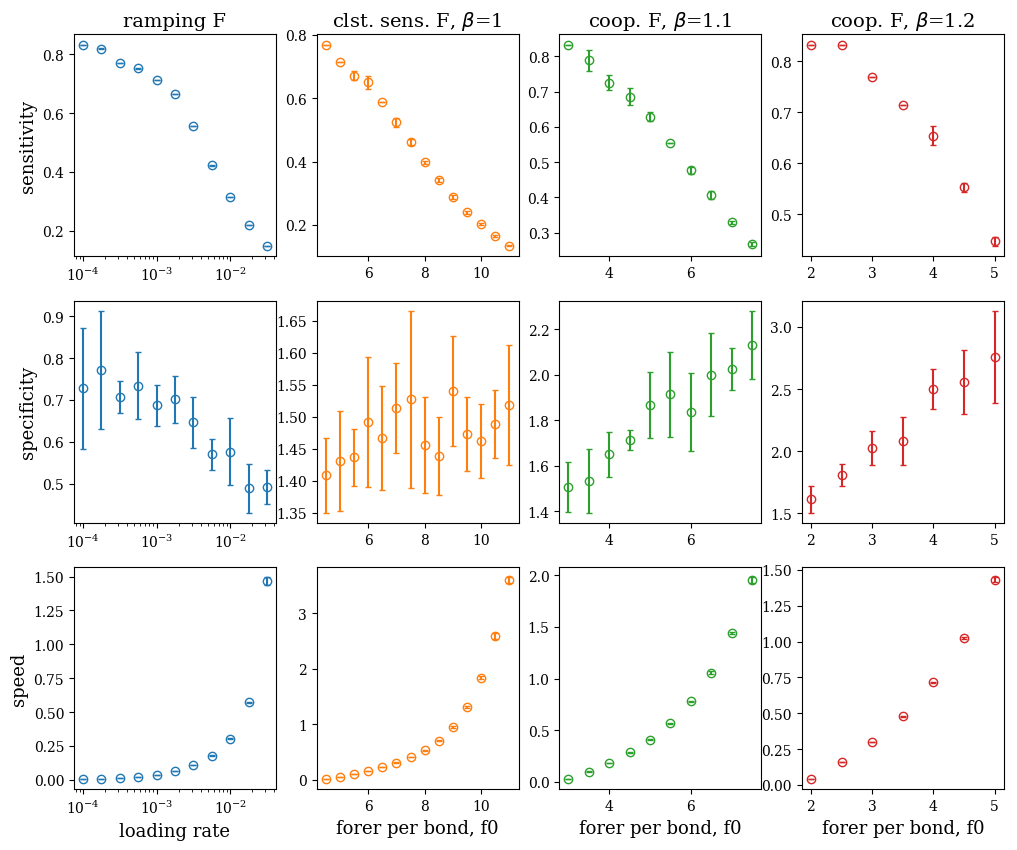

In [72]:
def plotData(ax, mydata, cr="C0", scale="linear"):
    qty_list = ["sens2", "spec", "spd"]
    for i,qty in enumerate(qty_list):
        ax[i].errorbar(mydata.dataset["prm"], mydata.dataset[qty], yerr=mydata.dataset[qty+"_std"], fmt="o", capsize=2, fillstyle='none', color=cr)
        ax[i].set_xscale(scale)
    return

figs, axs = plt.subplots(figsize=(12,10), nrows=3, ncols=4, dpi=100)

axs[0, 0].set_title("ramping F", fontsize=14)
axs[0, 1].set_title(r"clst. sens. F, $\beta$=1", fontsize=14)
axs[0, 2].set_title(r"coop. F, $\beta$=1.1", fontsize=14)
axs[0, 3].set_title(r"coop. F, $\beta$=1.2", fontsize=14)

axs[0, 0].set_ylabel("sensitivity", fontsize=13)
axs[1, 0].set_ylabel("specificity", fontsize=13)
axs[2, 0].set_ylabel("speed", fontsize=13)

axs[2, 0].set_xlabel("loading rate", fontsize=13)
axs[2, 1].set_xlabel("forer per bond, f0", fontsize=13)
axs[2, 2].set_xlabel("forer per bond, f0", fontsize=13)
axs[2, 3].set_xlabel("forer per bond, f0", fontsize=13)

plotData(axs[:, 0], ramp_data, cr="C0",scale="log")
plotData(axs[:, 1], cluster_data, cr="C1")
plotData(axs[:, 2], coop1_data, cr="C2")
plotData(axs[:, 3], coop2_data, cr="C3")
plt.show()

### Plot the pareto front

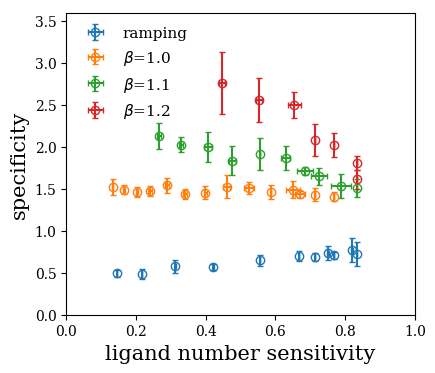

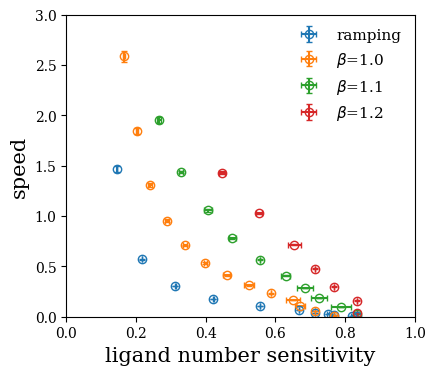

In [71]:
#### plot the pareto front

reload(pf)
labels=["ramping", r"$\beta$=1.0",r"$\beta$=1.1",r"$\beta$=1.2"]
pf.plot_data([ramp_data, cluster_data, coop1_data, coop2_data], xq="sens2", yq="spec", xlim=(0,1), ylim=(0,3.6), labels=labels)


pf.plot_data([ramp_data, cluster_data, coop1_data, coop2_data], xq="sens2", yq="spd", xlim=(0,1), ylim=(0,3), labels=labels)

